## Preguntas a rsponder 

1) Campos totalmente nulos para excluir 
2) ¿Cuantos Tags en promedio tiene cada producto? ¿Se relaccionan con el vendedor o la marca del producto? 'product_tags' -  'product_vendor'
3) ¿Promedio de palabras de la descripcion de los productos? (es suficientemente desccriptivo para una estrategia de retrieval)  'product_description',
4) ¿La marca del producto esta en el titulo generalmente? - ¿Que tan descriptivo es el titulo (promedio de palabras)? 'product_title' 
5) ¿Es adecuado usar el titulo y descripcion del producto para los embeddings? 'product_title' - 'product_description'

## Carga de datos

In [1]:
import pandas as pd 
import unicodedata
import re

In [ ]:
def limpiar_nombre(col):
    # minúsculas
    col = col.lower()
    # reemplazar espacios por "_"
    col = col.replace(" ", "_")
    # eliminar caracteres no alfanuméricos o "_"
    col = re.sub(r"[^\w]+", "", col)  
    # quitar "_" al inicio o final (si quedó sobrante)
    col = col.strip("_")
    return col


shopify_data = pd.read_excel('../data/raw/shopify-analítica.xlsx')
shopify_data.columns = [limpiar_nombre(col) for col in shopify_data.columns]
shopify_data.head(2)

## Visualización de ejemplos

In [ ]:
shopify_data.iloc[0,:].to_dict()

In [4]:
'REPUESTOS PARA MOTO',
'NaN',
'TAPA PARA MOTO',
'SOPORTES',
'REPUESTO',
'TORNILLO',
'KIT PISTON',
'DIRECCIONAL',
'BUJE PARA MOTO',
'RESORTES DE MOTO',
'Repuestos',
'CARENAJE',
'RETEN PARA MOTO',
'PISTERAS',
'GUARDABARRO',
'CABLE ACELERADOR',
'KIT ARRASTRE',

('KIT ARRASTRE',)

In [5]:
# Ejemplos de marcas en el titulo

'kymco agility 125 Rs',
'Eco 100 Hero'
'Rtx 150 Akt'
'Eco Deluxe Hero'
'Dt 125K Yamaha'
'Gs500 Suzuki'

'Gs500 Suzuki'

In [ ]:
shopify_data[shopify_data.product_type == 'CABLE ACELERADOR'].iloc[100,:].to_dict()

## Completitud de los datos

### Nulos 

In [7]:
# Porcentaje de nulos por columna
porcentaje_nulos = (shopify_data.isnull().mean() * 100).round(2)

# Mostrar como DataFrame ordenado de mayor a menor
porcentaje_nulos = porcentaje_nulos.reset_index()
porcentaje_nulos.columns = ["columna", "porcentaje_nulos"]
porcentaje_nulos = porcentaje_nulos.sort_values(by="porcentaje_nulos", ascending=False)

print(porcentaje_nulos)

                                    columna  porcentaje_nulos
13           product_taxonomy_category_name             98.35
12             product_taxonomy_category_id             98.35
7                        product_meta_title             98.12
8                  product_meta_description             61.50
16                 product_image_position_1             61.40
5                       product_description              8.29
6          product_description_without_html              8.29
11                             product_tags              7.83
14                             product_type              4.96
0                                product_id              0.06
15                           product_vendor              0.06
9    product_online_store_url_custom_domain              0.06
10  product_online_store_url_shopify_domain              0.06
4                             product_title              0.06
3                            product_handle              0.06
1       

### Precio 0

In [8]:
total = len(shopify_data)

# % con precio 0
precio_cero = (shopify_data.variant_price == 0.0).sum()
pct_precio_cero = round(precio_cero / total * 100, 2)

# % con precio 0 y sin descripción
precio_cero_sin_desc = ((shopify_data.variant_price == 0.0) & 
                        (shopify_data.product_description_without_html.isnull())).sum()
pct_precio_cero_sin_desc = round(precio_cero_sin_desc / total * 100, 2)

print(f"Productos con precio 0: {precio_cero} ({pct_precio_cero}%)")
print(f"Productos con precio 0 y sin descripción: {precio_cero_sin_desc} ({pct_precio_cero_sin_desc}%)")

Productos con precio 0: 150 (0.55%)
Productos con precio 0 y sin descripción: 1 (0.0%)


### Variables descriptivas con valores vaciíos ("") y nulos 

In [9]:
# Columnas a analizar
cols = [
    'product_title',
    'product_description_without_html',
    'product_vendor',
    'product_type',
    'product_tags'
]

analisis = []

for col in cols:
    total = len(shopify_data)
    
    # Nulos
    nulos = shopify_data[col].isnull().sum()
    pct_nulos = round(nulos / total * 100, 2)
    
    # Vacíos entre no nulos
    vacios = (shopify_data[col].fillna('').str.strip() == '').sum() - nulos
    pct_vacios = round((vacios / (total - nulos)) * 100, 2) if total - nulos > 0 else 0
    
    analisis.append({
        'columna': col,
        'total_registros': total,
        'nulos': nulos,
        '%_nulos': pct_nulos,
        'vacios_entre_no_nulos': vacios,
        '%_vacios_entre_no_nulos': pct_vacios
    })

df_analisis = pd.DataFrame(analisis)
df_analisis


,columna,total_registros,nulos,%_nulos,vacios_entre_no_nulos,%_vacios_entre_no_nulos
0,product_title,27479,17,0.06,0,0.0
1,product_description_without_html,27479,2277,8.29,0,0.0
2,product_vendor,27479,17,0.06,0,0.0
3,product_type,27479,1362,4.96,0,0.0
4,product_tags,27479,2152,7.83,0,0.0


## Analisis de variables descriptivas de los productos

### 1) Distribución del número de palabras en **product_title** y **product_description_without_html**

Distribución de número de palabras - Título
count    27479.000000
mean         7.144328
std          2.281675
min          0.000000
25%          6.000000
50%          7.000000
75%          8.000000
max         20.000000
Name: title_word_count, dtype: float64

Distribución de número de palabras - Descripción
count    27479.000000
mean        78.999127
std         32.065620
min          0.000000
25%         72.000000
50%         83.000000
75%         98.000000
max        410.000000
Name: desc_word_count, dtype: float64


<Axes: >

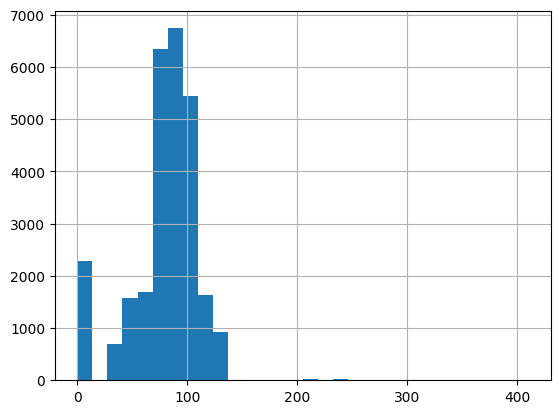

In [10]:
# Calcular cantidad de palabras por título y descripción
shopify_data['title_word_count'] = shopify_data['product_title'].fillna('').str.split().apply(len)
shopify_data['desc_word_count'] = shopify_data['product_description_without_html'].fillna('').str.split().apply(len)

# Resumen estadístico
print("Distribución de número de palabras - Título")
print(shopify_data['title_word_count'].describe())

print("\nDistribución de número de palabras - Descripción")
print(shopify_data['desc_word_count'].describe())

# También puedes ver la distribución en forma de histograma si usas notebooks:
shopify_data['desc_word_count'].hist(bins=30)

### 2) Diferentes proveedores **product_vendor** y conteo de cada uno

In [11]:
# Conteo por vendor (incluyendo NaN como categoría)
vendor_counts = shopify_data['product_vendor'].fillna('NaN').astype(str).str.strip().replace('', 'NaN').value_counts()

# Total de registros
total_registros = len(shopify_data)

# Crear DataFrame con conteo y porcentaje
vendor_summary = pd.DataFrame({
    'conteo': vendor_counts,
    'porcentaje': (vendor_counts / total_registros * 100).round(2)  # porcentaje respecto al total
})
display(vendor_summary)

vendor_req = vendor_summary[vendor_summary.conteo >= 70].index.tolist()

,conteo,porcentaje
product_vendor,,
YAMAHA,5477,19.93
GENERICO,4295,15.63
BAJAJ,3988,14.51
SUZUKI,3346,12.18
HONDA,3136,11.41
AKT,1952,7.10
KYMCO,1079,3.93
VICTORY,812,2.95
HERO,762,2.77


In [12]:
vendor_req

['YAMAHA',
 'GENERICO',
 'BAJAJ',
 'SUZUKI',
 'HONDA',
 'AKT',
 'KYMCO',
 'VICTORY',
 'HERO',
 'TVS',
 'KAWASAKI',
 'KTM',
 'MICHELIN',
 'PIRELLI',
 'BENELLI',
 'KONTROL',
 'METZELER',
 'ROYAL ENFIELD']

**Observaciones:**

- Por ahora solo se consideran los proveedores/marcas con 70 o mas registros.
- Agregar un campo que indique si el respuesto es **Original** o **Generico**.
- Se ha identificado las marcas que corresponden a llantas.

#### **¿Que proveedores de llantas hay?**

In [13]:
# =========================
# 1) Normalización de texto
# =========================
def _normalize(s: pd.Series) -> pd.Series:
    """
    Minúsculas + remueve tildes/diacríticos.
    """
    s = s.fillna("").astype(str).str.lower()
    s = s.apply(lambda x: unicodedata.normalize("NFD", x))
    s = s.str.replace(r"[\u0300-\u036f]", "", regex=True)  # quita diacríticos
    return s

# Normalizamos el título
title_norm = _normalize(shopify_data["product_title"])

# ===========================================
# 2) Patrón para detectar llantas por el título
#    (evita grupos de captura usando ?:)
# ===========================================
pattern = r"\b(?:llantas?|neumaticos?|tire?s?)\b"

# Máscara: productos cuyo título sugiere llantas
mask_llantas = title_norm.str.contains(pattern, regex=True, na=False)

# Subconjunto (opcional, si quieres inspeccionar)
df_llantas_title = shopify_data[mask_llantas].copy()

# ===========================================
# 3) Limpieza/normalización de vendor (marca)
# ===========================================
vendor_clean = (
    shopify_data['product_vendor']
    .fillna('NaN')
    .astype(str)
    .str.strip()
    .replace('', 'NaN')
    .str.upper()
)

# ===========================================
# 4) Totales globales y por marca
# ===========================================
total_por_vendor = vendor_clean.value_counts().rename('total')
llantas_por_vendor = vendor_clean[mask_llantas].value_counts().rename('llantas')

# Unimos y calculamos % de llantas por marca
resumen = (
    pd.concat([total_por_vendor, llantas_por_vendor], axis=1)
      .fillna(0)
      .astype({'total': int, 'llantas': int})
)
resumen['pct_llantas'] = (resumen['llantas'] / resumen['total'] * 100).round(2)

resumen.sort_values(['pct_llantas', 'llantas'], ascending=[False, False])

,total,llantas,pct_llantas
product_vendor,,,
MICHELIN,142,142,100.00
PIRELLI,129,129,100.00
KONTROL,77,77,100.00
METZELER,74,74,100.00
TIMSUN,56,56,100.00
IRC,51,51,100.00
CHAOYANG,49,49,100.00
DUNLOP,49,49,100.00
KENDA,41,41,100.00


In [14]:
marcas_llantas = resumen[resumen.pct_llantas==100].index.tolist()
len(marcas_llantas)

16

In [15]:
marcas_llantas

['MICHELIN',
 'PIRELLI',
 'KONTROL',
 'METZELER',
 'TIMSUN',
 'IRC',
 'CHAOYANG',
 'DUNLOP',
 'KENDA',
 'BRIDGESTONE',
 'QUEEN',
 'CEAT',
 'MRF',
 'EUROGRIP',
 'DIAMOND',
 'DURO']

### 3) Diferentes tipos (**product_type**) y conteo de cada uno

In [16]:
# Conteo por vendor (incluyendo NaN como categoría)
product_type_counts = shopify_data['product_type'].fillna('NaN').astype(str).str.strip().replace('', 'NaN').value_counts()

# Total de registros
total_registros = len(shopify_data)

# Crear DataFrame con conteo y porcentaje
product_type_summary = pd.DataFrame({
    'conteo': product_type_counts,
    'porcentaje': (product_type_counts / total_registros * 100).round(2)  # porcentaje respecto al total
})
display(product_type_summary.head(50))
# product_type_summary.index.tolist()

,conteo,porcentaje
product_type,,
REPUESTOS PARA MOTO,2094,7.62
NaN,1362,4.96
TAPA PARA MOTO,816,2.97
SOPORTES,725,2.64
REPUESTO,703,2.56
TORNILLO,652,2.37
KIT PISTON,543,1.98
DIRECCIONAL,535,1.95
BUJE PARA MOTO,517,1.88


In [17]:
product_type_summary.index.tolist()

['REPUESTOS PARA MOTO',
 'NaN',
 'TAPA PARA MOTO',
 'SOPORTES',
 'REPUESTO',
 'TORNILLO',
 'KIT PISTON',
 'DIRECCIONAL',
 'BUJE PARA MOTO',
 'RESORTES DE MOTO',
 'Repuestos',
 'CARENAJE',
 'RETEN PARA MOTO',
 'PISTERAS',
 'GUARDABARRO',
 'CABLE ACELERADOR',
 'KIT ARRASTRE',
 'ESPEJO RETROVISOR',
 'ARANDELA',
 'PIÑON CAJA DE CAMBIOS',
 'ANILLOS PISTON',
 'DOBLE PROPOSITO-OFF ROAD',
 'FILTRO DE AIRE',
 'TUERCA',
 'COMANDO',
 'EMPAQUE GENERAL',
 'POSAPIE',
 'FAROLA',
 'ORING de MOTO',
 'PASTILLAS DE FRENO',
 'RODAMIENTO',
 'PIM PARA MOTO',
 'CAUCHO DE MOTO',
 'CABLE CLUTCH',
 'DISCO CLUTCH',
 'SWITCH ENCENDIDO',
 'MANIGUETA DE FRENO',
 'CILINDRO',
 'DISCO DE FRENO',
 'CABLE TACOMETRO',
 'CANASTILLA PARA MOTO',
 'REGULADOR',
 'MANUBRIO',
 'PLATO DE BOBINAS',
 'AMORTIGUADORES',
 'TAPON DE MOTO',
 'EMPAQUE CULATA',
 'PIÑON DE ARRASTRE',
 'GUARDAPOLVO',
 'ARBOL DE LEVAS',
 'EJE LLANTA',
 'VELOCÍMETRO',
 'BALANCIN',
 'CADENILLA DE DISTRIBUCION',
 'PEDAL DE CAMBIOS',
 'STOP',
 'MANIGUETA CLUTCH

In [18]:
product_type_summary.shape

(433, 2)

In [ ]:
# Conteo por vendor (incluyendo NaN como categoría) (SOLO LLANTAS)
shopify_data_llantas = shopify_data[shopify_data.product_vendor.isin(marcas_llantas)]
product_type_counts = shopify_data_llantas['product_type'].fillna('NaN').astype(str).str.strip().replace('', 'NaN').value_counts()

# Total de registros
total_registros = len(shopify_data_llantas)

# Crear DataFrame con conteo y porcentaje
product_type_summary = pd.DataFrame({
    'conteo': product_type_counts,
    'porcentaje': (product_type_counts / total_registros * 100).round(2)  # porcentaje respecto al total
})
display(product_type_summary.head(50))

# product_type_summary.index.tolist()

,conteo,porcentaje
product_type,,
PISTERAS,393,51.31
DOBLE PROPOSITO-OFF ROAD,282,36.81
SCOOTER,68,8.88
ENDURO,16,2.09
NEUMATICO,7,0.91


**Observaciones:**

- Analizar la mejor estrategia para usar el tipo de producto.  Son 433 en total. Este podría ser usado mas como un sub clasificacion y considerar otra mas global de tipo de producto.
- Cuando se tratan de llantas el tipo de producto sería mas bien como un subtipo de producto. En este caso el tipo de producto debería ser llanta.

In [28]:
shopify_data['product_type'].replace("PISTERA", "PISTERAS", inplace=True)

### 4) Análisis de product_tags: diferentes tags por producto y total de tags únicos

In [30]:
# Convertir tags en listas separadas por coma
shopify_data['tags_list'] = shopify_data['product_tags'].fillna('').apply(lambda x: [t.strip() for t in x.split(',') if t.strip() != ''])

# Conteo de cantidad de tags por producto
shopify_data['tags_count'] = shopify_data['tags_list'].apply(len)

# Distribución de cantidad de tags por producto
print("Distribución de número de tags por producto:")
print(shopify_data['tags_count'].describe())

Distribución de número de tags por producto:
count    27479.000000
mean         1.428618
std          1.224934
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         14.000000
Name: tags_count, dtype: float64


In [31]:
# Lista de todos los tags únicos y su conteo total
all_tags = pd.Series([tag for tags in shopify_data['tags_list'] for tag in tags])
tag_counts = all_tags.value_counts()
print("\nTags únicos y su frecuencia:")
tag_counts.head(50)


Tags únicos y su frecuencia:


YAMAHA                           4963
AÑO_TODOS LOS AÑOS               4877
GENERICO                         4144
BAJAJ                            3637
SUZUKI                           2945
HONDA                            2801
AKT                              1809
KYMCO                             952
OULET                             706
HERO                              665
TVS                               552
KAWASAKI                          545
VICTORY                           417
MODELO_BWS 125                    383
RIN_17                            382
MODELO_CRYTON                     356
L17                               298
MODELO_AKT 110                    243
MODELO_LIBERO 125                 239
MODELO_FZ 16                      238
MODELO_OTROS REPUESTOS YAMAHA     234
MODELO_YBR 125                    225
MODELO_XTZ 250                    204
MODELO_DT 125                     198
ALTO_70                           197
MODELO_NMAX                       184
ALTO_90     

In [32]:
tag_counts.shape

(241,)

### Resumen

- Excluir registros con nulos en **product_online_store_url_custom_domain**.
- Excluir registros con **variant_price** igual a 0. Suelen estar agotados.
- No considerar los campos  **product_taxonomy_category_name**, **product_taxonomy_category_id**, **product_meta_title**, **product_meta_description**
- Por ahora solo se consideran los proveedores/**marcas** con 70 o mas registros.
- Agregar un campo que indique si el respuesto es **Original** o **Generico**.
- Se ha identificado las marcas que corresponden a llantas. Estas suelen venir con un tipo de producto muy afin de las llantas (sccoter, pistera, ..), sin el contexto de "llantas" se pueden malinterpretar
- Determinar estrategia para usar el tipo de producto.  Son 433 en total. Este podría ser usado mas como una **sub clasificacion y considerar otra mas global** de tipo de producto, que permita filtros menos reestrictivos.
- Cuando se tratan de llantas el tipo de producto sería mas bien como un subtipo de producto. En este caso el tipo de producto debería ser llanta.
- Con GenAI:
    - Determinar los metadatos a considerar para un producto.
    - Determinar los tipos de productos - junto con descripcion y ejemplos de productos especificos - a considerar.
    - Extraer el "modelo" del titulo del producto y El "tipo de producto" (categoria mas general) con titulo y descripcion. Un modelo de una moto luce como 'kymco agility 125 Rs', 'Eco 100 Hero', 'Rtx 150 Akt', 'Eco Deluxe Hero', 'Dt 125K Yamaha', 'Gs500 Suzuki',... pero no siempre aparecen, por ejemplo si son llantas no tiene sentido que aparezca un modelo, porque una misma referencia puede usarse un varios modelos.

### Pipeline de limpieza de datos

In [33]:
# --- 0) Copia de trabajo
df = shopify_data.copy()

# --- 1) Normalizar vendor (para contar y filtrar con consistencia)
df["vendor_clean"] = (
    df["product_vendor"]
    .fillna("NaN").astype(str).str.strip()
    .replace("", "NaN")
    .str.upper()
)

# --- 2) Excluir registros con URL nula o vacía
url_col = "product_online_store_url_custom_domain"
df = df[df[url_col].notna() & (df[url_col].astype(str).str.strip() != "")]

# --- 3) Excluir registros con variant_price == 0 (agotar/placeholder)
df["variant_price_num"] = pd.to_numeric(df["variant_price"], errors="coerce")
# Si quieres, también puedes excluir precios NaN por seguridad:
# df = df[df["variant_price_num"].notna()]
df = df[df["variant_price_num"] > 0]

# --- 4) Considerar solo proveedores/marcas con >= 70 registros
vendor_counts = df["vendor_clean"].value_counts()
vendors_validos = set(vendor_counts[vendor_counts >= 70].index)
df = df[df["vendor_clean"].isin(vendors_validos)]

# --- 5) Agregar campo booleana: ¿el producto es llanta según la marca?
marcas_llantas_norm = {m.upper() for m in marcas_llantas}
df["es_llanta"] = (df["vendor_clean"].isin(marcas_llantas_norm)) | (df.product_type == 'NEUMATICO')

# --- 6) Agregar campo booleana: ¿el producto es original segun vendor_clean?
df["es_original"] = df["vendor_clean"]!="GENERICO"

# --- 7) Seleccionar columnas relevantes y renombrar
cols_map = {
    "product_id": "id_producto",
    "product_title": "titulo_producto",
    "product_description_without_html": "descripcion",
    "product_online_store_url_custom_domain": "url_tienda",
    "product_tags": "tags",
    "product_type": "tipo_producto",
    "vendor_clean": "marca",
    "es_llanta": "es_llanta",
    "es_original": "es_original",
    "variant_price_num": "precio_producto",
}
cols_existentes = [c for c in cols_map.keys() if c in df.columns]
df = (
    df[cols_existentes]
    .rename(columns=cols_map)
    .reset_index(drop=True)
)
df["id_producto"] = df["id_producto"].astype(int).astype(str)

# --- 8) (Opcional) Reordenar/seleccionar columnas finales y reset index
df = df.reset_index(drop=True)


# --- 9) Resumen rápido
print(f"Vendors con >=70 registros: {len(vendors_validos)}")
print(f"Registros finales: {len(df)}")
print("Top vendors (post-filtrado):")
print(df['marca'].value_counts().head(40))

Vendors con >=70 registros: 18
Registros finales: 26642
Top vendors (post-filtrado):
marca
YAMAHA           5465
GENERICO         4204
BAJAJ            3977
SUZUKI           3344
HONDA            3133
AKT              1936
KYMCO            1073
VICTORY           812
HERO              760
TVS               644
KAWASAKI          566
KTM               142
MICHELIN          142
PIRELLI           129
BENELLI            94
KONTROL            77
METZELER           74
ROYAL ENFIELD      70
Name: count, dtype: int64


In [ ]:
df.head()

In [ ]:
df[df.tipo_producto == 'PISTERAS']

In [ ]:
df.iloc[15000,:].to_dict()

In [37]:
df.to_pickle("../data/curated/shopify_data.pkl")

- 'product_id'
- 'product_title'
- 'product_description_without_html'
- 'product_online_store_url_custom_domain'
- 'product_tags'
- 'product_type'
- 'product_vendor' -- 'vendor_clean'


**Metadatos Relevantes**

- Del producto:
    -  Nombre
    - Original / Generico
    - Tipo de producto / Sub tipo de producto
    - Marca (generica)
    - Descripcion
    - Tags (pero se deben ajustar o enriquecer para tenga mas sentido para GenAI)
    - Modelo de moto: marca y modelo de la moto, por ejemplo 'kymco agility 125 Rs', 'Eco 100 Hero', 'Rtx 150 Akt', 'Eco Deluxe Hero', 'Dt 125K Yamaha', 'Gs500 Suzuki'. 

In [ ]:
## Proveedores/Marcas de llantas



16

In [65]:
set(marcas_llantas) & set(vendor_req)

{'KONTROL', 'METZELER', 'MICHELIN', 'PIRELLI'}

In [45]:
# 0) Normalizar vendor para agrupar (evita duplicados por mayúsculas/espacios)
vendor_clean = (
    shopify_data['product_vendor']
    .fillna('NaN')
    .astype(str)
    .str.strip()
    .replace('', 'NaN')
    .str.upper()
)

# 1) Totales por marca
total_por_vendor = vendor_clean.value_counts().rename('total')

# 2) Totales de "llantas" por marca (usando tu máscara)
llantas_por_vendor = vendor_clean[mask_llantas].value_counts().rename('llantas')

# 3) Unir y calcular porcentaje
resumen = (
    pd.concat([total_por_vendor, llantas_por_vendor], axis=1)
      .fillna(0)
      .astype({'total': int, 'llantas': int})
)
resumen['pct_llantas'] = (resumen['llantas'] / resumen['total'] * 100).round(2)

resumen.sort_values('pct_llantas', ascending=False)

,total,llantas,pct_llantas
product_vendor,,,
DUNLOP,49,49,100.00
TIMSUN,56,56,100.00
CHAOYANG,49,49,100.00
METZELER,74,74,100.00
KONTROL,77,77,100.00
PIRELLI,129,129,100.00
MICHELIN,142,142,100.00
KENDA,41,41,100.00
BRIDGESTONE,32,32,100.00


In [18]:
# --- 1) Normalizar texto (minúsculas, sin tildes) para buscar robusto ---
def _normalize(s: pd.Series) -> pd.Series:
    s = s.fillna("").astype(str).str.lower()
    # quitar tildes/diacríticos
    return s.apply(lambda x: unicodedata.normalize("NFD", x))\
            .str.replace(r"[\u0300-\u036f]", "", regex=True)

# Normalizamos el título
title_norm = _normalize(shopify_data["product_title"])

# --- 2) Patrón para "llanta" y variantes útiles (opcional: neumatico/neumático, tire) ---
pattern = r"\b(?:llantas?|neumaticos?|tire?s?)\b"

# Filtrar filas cuyo título menciona llantas
mask_llantas = title_norm.str.contains(pattern, regex=True, na=False)
df_llantas_title = shopify_data[mask_llantas].copy()

# --- 3) Vendors únicos y conteo ---
vendors_counts = (
    df_llantas_title["product_vendor"]
    .fillna("NaN")
    .astype(str)
    .str.strip()
    .replace("", "NaN")
    .value_counts(dropna=False)
)

vendors_unicos = sorted(vendors_counts.index.tolist())

In [19]:
df_llantas_title

vendor_llantas_counts = df_llantas_title['product_vendor'].value_counts(dropna=False)
print(vendor_llantas_counts)

product_vendor
MICHELIN       142
PIRELLI        129
KONTROL         77
METZELER        74
GENERICO        57
TIMSUN          56
IRC             51
CHAOYANG        49
DUNLOP          49
YAMAHA          43
KENDA           41
BRIDGESTONE     32
QUEEN           28
BAJAJ           23
CEAT            22
SUZUKI          21
HONDA           20
Mundimotos      20
AKT             19
MRF              9
KYMCO            6
HERO             5
TVS              5
EUROGRIP         3
DIAMOND          3
KAWASAKI         2
DURO             1
Name: count, dtype: int64


In [ ]:
df_llantas_title[df_llantas_title['product_vendor'] == 'TIMSUN']

**Falsos Positivos en proveedotes de llantas**

- KAWASAKI
- TVS
- HERO
- KYMCO
- AKT
- HONDA
- SUZUKI

**Excluir proveedores con pocos productos:** en general estan agotados los productos
- Mundimotos
- 

In [ ]:
'GENERAL', 'GENERICO'

In [ ]:
marcas_llantas = [
    "MICHELIN",
    "PIRELLI",
    "METZELER",
    "GENERAL",
    "TIMSUN",
    "IRC",
    "CHAOYANG",
    "DUNLOP",
    "KENDA",
    "BRIDGESTONE",
    "CEAT",
    "MRF",
    "EUROGRIP",
    "DURO"
]

In [ ]:
shopify_data.iloc[24217,:].to_dict()

In [ ]:
shopify_data.iloc[27478,:].to_dict()#['variant_price'] == 0

In [59]:
shopify_data['product_tags'].isna().sum()

np.int64(2152)

In [34]:
# shopify_data['product_type'].value_counts().to_dict()

In [ ]:
shopify_data[shopify_data.product_description != shopify_data.product_description_without_html]

In [ ]:
shopify_data.iloc[28,:].to_dict()

In [ ]:
'product_title',
'product_description_without_html',
'product_vendor',
'product_type',
'product_tags',

In [ ]:
['product_id',
 'variant_id',
 'variant_sku',
 'product_handle',


 'product_description_without_html',
 'product_meta_title',
 'product_meta_description',
 'product_online_store_url_custom_domain',
 'product_online_store_url_shopify_domain',
 'product_tags',
 'product_taxonomy_category_id',
 'product_taxonomy_category_name',
 'product_type',
 'product_vendor',
 'product_image_position_1',
 'variant_price',
 'variant_title']
